In [1]:
!pip install itkwidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import nibabel as nib                                                     
import itk                                                                
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate

%matplotlib inline
import seaborn as sns

In [3]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [4]:
from google.colab import drive
drive.mount('./gdrive')

Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [5]:
import os
os.chdir("/content/gdrive/MyDrive/brats2021")

In [6]:
import tarfile
file = tarfile.open('/content/gdrive/MyDrive/brats2021/BraTS2021_Training_Data.tar')

file.extractall('./brain_images')
file.close()

In [7]:
image_path = "./brain_images/BraTS2021_00284/BraTS2021_00284_t1.nii.gz"
image_obj = nib.load(image_path)
type(image_obj)

nibabel.nifti1.Nifti1Image

In [8]:
image_data = image_obj.get_fdata()
print(type(image_data))
image_data.shape

<class 'numpy.ndarray'>


(240, 240, 155)

In [9]:
def visualize_3d(layer):
    plt.figure(figsize=(10, 5))
    plt.imshow(image_data[:, :, layer], cmap='gray');
    plt.axis('off')
    return layer

interact(visualize_3d, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

In [10]:
layer = 50
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

def visualize_3d_labels(layer):
    mask = nib.load('./brain_images/BraTS2021_00284/BraTS2021_00284_seg.nii.gz').get_fdata()
    plt.imshow(mask[:,:,layer])
    plt.axis('off')
    plt.tight_layout()

interact(visualize_3d_labels, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

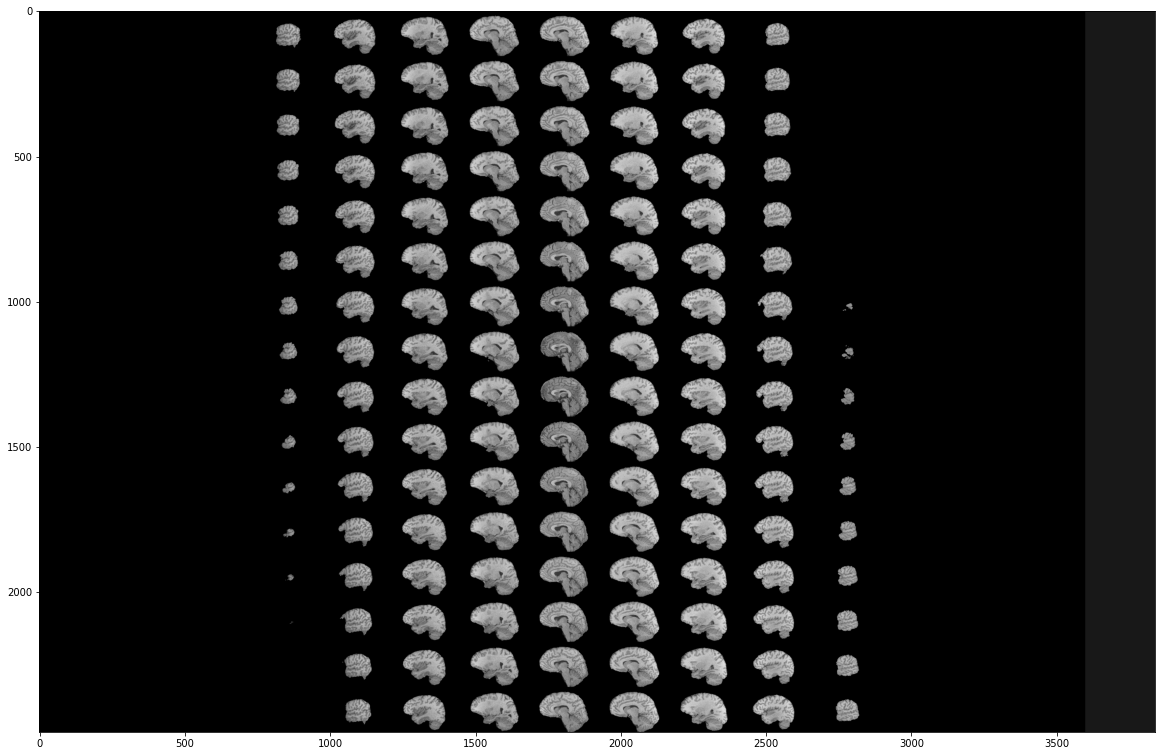

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (20,20))
ax1.imshow(rotate(montage(image_data[:,:,:]), 90, resize=True), cmap ='gray')

In [12]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, epsilon=0.00001):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    
    """
    axis = (0,1,2,3)
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
IMG_SIZE=128

In [14]:
TRAIN_DATASET_PATH = './brain_images'

file = tarfile.open('/content/gdrive/MyDrive/brats2021/BraTS2021_00621.tar')
file.extractall('./val_brain_images')
file.close()

In [15]:
VALIDATION_DATASET_PATH = '../val_brain_images'

In [16]:
import os
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

In [17]:
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [18]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 128 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [19]:
keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 128, 128))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
             X[j+(VOLUME_SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

             X[j+(VOLUME_SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
             
             
             y[j +VOLUME_SLICES*c,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

        X = X.reshape(1,128,128,128,2)
        y = y.reshape(1,128,128,128)
        # Generate masks
        y[y==4] = 3;
        y = tf.one_hot(y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        #Y = np.array(Y).reshape(1,128,128,128)
        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [20]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),
      csv_logger
    ]

In [21]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)
  
  X = Activation('relu')(X)
    
  X = add([input_mat,X]);
  
  return X


def Vnet_3d(input_img, n_filters = 8, dropout = 0.2, batch_norm = True):

  #c1 = conv_block(input_img,n_filters,3,batch_norm)
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  #c1 = add([c1,input_img])
  
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  
  c3 = conv_block(c2 , n_filters*2,5,True)
  
  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)
  
  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)
    
  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  #c6 = conv_block(p5, n_filters*8,5,True)
  #p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c6)

  p7 = conv_block(p6,n_filters*16,5,True)
    
  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);

  
  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);
    
  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);
  
  
  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);
  
  

  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)

  model = Model(inputs=input_img, outputs=outputs)

  return model

In [22]:
input_layer = Input((128,IMG_SIZE, IMG_SIZE, 2))

model1 = Vnet_3d(input_layer)
model1.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                                dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, 
                                                                                                                dice_coef_edema ,dice_coef_enhancing] )

model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 2)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  2008        ['input_1[0][0]']                
                                8, 8)                                                             
                                                                                                  
 conv3d_1 (Conv3D)              (None, 64, 64, 64,   1040        ['conv3d[0][0]']                 
                                16)                                                           

In [ ]:
history =  model1.fit(training_generator,
                     epochs=35,
                     steps_per_epoch=len(train_ids),
                     callbacks= callbacks,
                     validation_data = valid_generator
                     )  
model1.save("model_vnet_2mod.h5")

Epoch 1/35
850/850 [==============================] - ETA: 0s - loss: 0.0613 - accuracy: 0.9852 - mean_io_u: 0.4235 - dice_coef: 0.4172 - precision: 0.9881 - sensitivity: 0.9819 - specificity: 0.9966 - dice_coef_necrotic: 0.1354 - dice_coef_edema: 0.2981 - dice_coef_enhancing: 0.2418
Epoch 1: val_loss improved from inf to 0.11776, saving model to model_.01-0.117756.m5
850/850 [==============================] - 1419s 2s/step - loss: 0.0613 - accuracy: 0.9852 - mean_io_u: 0.4235 - dice_coef: 0.4172 - precision: 0.9881 - sensitivity: 0.9819 - specificity: 0.9966 - dice_coef_necrotic: 0.1354 - dice_coef_edema: 0.2981 - dice_coef_enhancing: 0.2418 - val_loss: 0.1178 - val_accuracy: 0.9720 - val_mean_io_u: 0.3750 - val_dice_coef: 0.3384 - val_precision: 0.9753 - val_sensitivity: 0.9697 - val_specificity: 0.9919 - val_dice_coef_necrotic: 0.0542 - val_dice_coef_edema: 0.1767 - val_dice_coef_enhancing: 0.1350 - lr: 0.0010
Epoch 2/35
850/850 [==============================] - ETA: 0s - loss: 0.0

In [ ]:
plot_model(model1, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [ ]:
print("Evaluate on test data")
results = model1.evaluate(test_generator, callbacks= callbacks)
print("test loss, test acc:", results)